In [1]:
#select where to run this notebook---
binder_or_localpc=True #True: if you want to run the script using binder or in your local PC
google_colab=False #True: if you want to run the script in google colab

In [2]:
%%capture
#!pip freeze. #to list the packages installed in colab
#or install without checking above (!but do it just once)---
if google_colab:
    !pip install numpy
    !pip install matplotlib
    !pip install netcdf4
    !pip install xarray
    !pip install scipy
    !pip install tqdm

In [3]:
#open packages---
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import os

In [4]:
#modify the local path in case you run this script in your computer---
if binder_or_localpc:
    main_dir="../"
if google_colab:
    #google colab path:
    mount_point='/content/gdrive/' #dir name for a temporal mount point (just for running this script)
    gdrive_path="MyDrive/colab_repos/" #the path in "my Google Drive" where you have cloned the repo
    main_dir=mount_point+gdrive_path
    #mount:
    from google.colab import drive
    drive.mount(mount_point)

In [5]:
#don't modify below names---
#AGU number:
agu_number="num" #put here the agu manuscript number
#name of the repository:
if binder_or_localpc: 
    dir_repo_name=""
if google_colab:
    #name of directories from the cloned github repo:
    dir_repo_name="paper_Atmospherically_Driven_Seasonal_Interannual_LTTS_MultipleInlet/"
dir_data="data/"
dir_figures="figures/"
#name of files with data:
file_large_scale_model_Tr="large_scale_model_Tr.nc"
file_large_scale_model_Te="large_scale_model_Te.nc"

In [6]:
#create dir figures if it does not exists---
if not os.path.exists(main_dir+dir_repo_name+dir_figures):
    os.makedirs(main_dir+dir_repo_name+dir_figures)

In [7]:
#set global parameters for figures---
glob_font_size=12
params = {'legend.fontsize':9,
          'axes.titlesize':glob_font_size,'axes.labelsize': glob_font_size, #size of titles, x-y labels 
          'xtick.labelsize':glob_font_size-1,'ytick.labelsize':glob_font_size-1, #size of xtick-labels, ytick-labels
          'xtick.major.size':2,'xtick.major.width':.8, #length and width of xticks marks
          'ytick.major.size':2,'ytick.major.width':.8,} #length and width of yticks marks
mpl.rcParams.update(params)

In [8]:
#open data---
ds_Tr_model=xr.open_dataset(main_dir+dir_repo_name+dir_data+file_large_scale_model_Tr)
ds_Te_model=xr.open_dataset(main_dir+dir_repo_name+dir_data+file_large_scale_model_Te)

In [9]:
#prepare the data to get statistics and for ploting---
def pre_proc(ds,variable="Tr",lag=1):
    result_cum_predictors=ds[f"{variable}_tilde_seasonal"].expand_dims(dim={"predictors":np.array(["seasonal"],dtype='object')},axis=1).rename(); del result_cum_predictors.attrs["long_name"]
    if lag==1:
        result_cum_predictors=xr.concat((result_cum_predictors,ds[f"{variable}_tilde_pcs_model_lag"]),dim="predictors").cumsum(dim='predictors')
        result_cum_predictors[dict(time=-1,predictors=range(1,4))]=np.nan
    else:
        result_cum_predictors=xr.concat((result_cum_predictors,ds[f"{variable}_tilde_pcs_model"]),dim="predictors").cumsum(dim='predictors')
    result_cum_predictors["predictors"]=["seasonal","+SCAN","+NAO","+EAP"]
    return result_cum_predictors

#compute several statistics---
def compute_statistics(target,prediction):
    rmse=(((target-prediction)**2).mean(dim='time'))**.5   
    std=target.std(dim='time') #use by default ddof=0
    rmse_norm=rmse/std*100
    var_exp=((prediction-prediction.mean(dim="time"))**2).mean(dim="time")/((target-target.mean(dim="time"))**2).mean(dim="time")*100
    r=xr.corr(target,prediction,dim='time')
    R2=1-((target-prediction)**2).sum(dim="time")/((target-target.mean(dim="time"))**2).sum(dim="time")
    sqrtR2=abs(R2)**.5
    names=['rmse','stde','rmse_norm','var_exp','R2','sqrtR2','r']
    stats=[rmse,std,rmse_norm,var_exp,R2,sqrtR2,r]
    for i in range(len(names)):
        stats[i].name=names[i]
    ds_stats=xr.merge(stats)
    return ds_stats 

#statistics using all available data (the full time series)---   
def get_statistics(target,result_cum_predictors,lag=1,anom=False):
    #target[dict(time=-1)]=np.nan #this will change the input array
    if lag==1:
        N=len(target.time)
        target=target.isel(time=range(0,N-1))
        result_cum_predictors=result_cum_predictors.isel(time=range(0,N-1))
    if anom: 
        target=target-result_cum_predictors.sel(predictors="seasonal").drop("predictors")
        result_cum_predictors=(result_cum_predictors-result_cum_predictors.sel(predictors="seasonal")).isel(predictors=slice(1,None))
        result_cum_predictors["predictors"]=["SCAN","+NAO","+EAP"]
    stats=compute_statistics(target,result_cum_predictors)
    return stats

#statistics per climatological month---
def get_statistics_clim(target,result_cum_predictors,lag=1,anom=True):
    if lag==1:
        N=len(target.time)
        target=target.isel(time=range(0,N-1))
        result_cum_predictors=result_cum_predictors.isel(time=range(0,N-1))
    if anom: 
        target=target-result_cum_predictors.sel(predictors="seasonal").drop("predictors")
        result_cum_predictors=(result_cum_predictors-result_cum_predictors.sel(predictors="seasonal")).isel(predictors=slice(1,None))
        result_cum_predictors["predictors"]=["SCAN","+NAO","+EAP"]
    target_months=target.groupby("time.month")
    result_cum_predictor_months=result_cum_predictors.groupby("time.month")
    stats_per_month=[]
    for i,j in zip(target_months,result_cum_predictor_months):
        stats_per_month.append(compute_statistics(i[1],j[1]))
    stats_per_month=xr.concat(stats_per_month,xr.DataArray(range(1,13),dims="months"))
    #stats_per_month=xr.concat(stats_per_month,pd.Index(range(1,13),name="months")) #the same as above, but using pandas index
    #print the PCs model stats using all components:
    names=['rmse','stde','rmse_norm','var_exp','R2','sqrtR2','r']
    a=np.round(stats_per_month.isel(predictors=-1),2).to_array().values
    print("stats using all PCs:")
    for i in range(6): print(names[i],a[i,:])
    return stats_per_month

In [10]:
def plot_statistics(target,result_cum_predictors,target_stats,target_anom_stats_per_month,variable):
    #
    fig=plt.figure(figsize=(8.5,5.2),dpi=600)
    gs = fig.add_gridspec(nrows=3, ncols=4, hspace=0.2, wspace=1)                   
    ax1 = fig.add_subplot(gs[0,:]); ax3 = fig.add_subplot(gs[-1,:2])
    ax2 = fig.add_subplot(gs[1,:]); ax4 = fig.add_subplot(gs[-1,-2:])
    #
    tm=target.time.values
    xticks_lab=np.arange(int(str(tm[0])[:4]),int(str(tm[-1])[:4])+4,4)
    xticks=[np.datetime64(str(i)+'-01-01') for i in xticks_lab]
    tt1=np.arange(np.datetime64("1980"),np.datetime64("2018"),2)
    tt2=np.arange(np.datetime64("1981"),np.datetime64("2017"),2)
    #
    target_clim=result_cum_predictors.sel(predictors="seasonal").drop("predictors")
    target_anom=target-target_clim
    result_cum_predictors_anom=result_cum_predictors-target_clim    
    if variable=="Tr":
        label1=r'$\tilde{T}_r$'
        label2=r'deseasonalized $\tilde{T}_r$' #deseasonalized
    else:
        label1=r'$\tilde{T}_e$'
        label2=r'deseasonalized $\tilde{T}_e$' #deseasonalized
    predictors=["SCAN","+NAO","+EAP"]
    #A)-----
    for i in range(len(tt1)-1): ax1.axvspan(tt1[i],tt2[i],alpha=0.5,color='lightgrey') 
    l0,=ax1.plot(tm,target,c='r',label=label1,lw=1.6)
    l1,=ax1.plot(tm,result_cum_predictors.sel(predictors='seasonal'),c='c',lw=1.2,ls='-',label="seasonal")
    l2,=ax1.plot(tm,result_cum_predictors.sel(predictors='+EAP'),ls='--',c='b',lw=1.2,label="seasonal + PCs model")
    if variable=="Tr":
        ax1.set_yticks(np.arange(5,30,5));ax1.set_ylim(4.5,23)
    else:
        ax1.set_yticks(np.arange(5,40,5));ax1.set_ylim(5,35)
    ax1.grid(ls=":",lw=.4);ax1.set_ylabel("(days)") 
    ax1.legend(handles=[l0,l1,l2],loc=(0.442,.84),ncol=3,framealpha=.7,facecolor='lightyellow', borderpad=0.1)
    ax1.set_xlim([np.datetime64('1979-11-01'),xticks[-1]])
    ax1.set_xticks(xticks); ax1.set_xticklabels(xticks_lab,fontsize=glob_font_size-1);
    ax1.tick_params(direction="in"); ax1.text(0.01,0.86,'a)',transform=ax1.transAxes,fontsize=glob_font_size) #fontweight='bold'
    #
    #B)---
    for i in range(len(tt1)-1): ax2.axvspan(tt1[i],tt2[i],alpha=0.5,color='lightgrey') 
    l0,=ax2.plot(tm,target_anom,c='r',lw=1.6,label=label2)
    l1,=ax2.plot(tm,result_cum_predictors_anom.sel(predictors="+EAP"),c='b',lw=.8,label="PCs model")
    if variable=="Tr":
        ax2.set_yticks(np.arange(-6,12,3));ax2.set_ylim(-7,7)
    else:
        ax2.set_yticks(np.arange(-12,13,4));ax2.set_ylim(-14,14)        
    ax2.grid(ls=":",lw=.4);ax2.set_ylabel("(days)") 
    ax2.legend(handles=[l0,l1],loc=(0.575,.84),ncol=2,frameon=True,framealpha=.7,facecolor='lightyellow', borderpad=0.1)
    ax2.set_xlim([np.datetime64('1979-11-01'),xticks[-1]])
    ax2.set_xticks(xticks); ax2.set_xticklabels("")
    ax2.tick_params(direction="in");
    ax2.text(0.01,0.86,'b)',transform=ax2.transAxes,fontsize=glob_font_size-.5)
    #
    #C)-----
    xlabels=list(target_stats.predictors.data)
    predictors_val=np.arange(1,5)
    l0,=ax3.plot(predictors_val,target_stats.var_exp,"-r",label=r"VAR$_{exp}$")
    ax3.plot(predictors_val,target_stats.var_exp,"-or",ms=4)
    if variable=="Tr":
        ax3.set_yticks(np.arange(68,100,5));ax3.set_ylim(68,98)
    else:
        ax3.set_yticks(np.arange(57,94,6));ax3.set_ylim(57,93)       
    ax3.tick_params(axis='y',colors='r',direction="in");ax3.grid(ls=":",lw=.4)
    ax3.set_xticks(predictors_val);ax3.set_xticklabels(xlabels)
    ax3.tick_params(direction="in"); ax3.text(0.01,1.04,'c)',transform=ax3.transAxes,fontsize=glob_font_size)
    ax3.text(-.097,1.08,'(%)',c='r',transform=ax3.transAxes,fontsize=glob_font_size-3)
    #
    ax3a=ax3.twinx()
    l1,=ax3a.plot(predictors_val,target_stats.r,"-b",label=f"R")
    ax3a.plot(predictors_val,target_stats.r,"ob",ms=4)
    if variable=="Tr":
        ax3a.set_yticks(np.arange(.8,.99,.03));ax3a.set_ylim(.8,.98)
    else:
        ax3a.set_yticks(np.arange(.75,.94,.03));ax3a.set_ylim(.75,.93)    
    ax3a.tick_params(axis='y',colors='b',direction="in")#;ax.set_ylabel(f"correlation $r$",c='b');
    #
    ax3.legend(handles=[l0,l1],loc=(0.9,-.35),ncol=3,framealpha=.7,facecolor='lightyellow', borderpad=0.1)        
    #
    #D)-----
    xlabels=['J','F','M','A','M','J','J','A','S','O','N','D']
    months=range(1,13)
    #
    ax4.plot(months,target_anom_stats_per_month.var_exp.isel(predictors=2),"r")
    ax4.set_yticks(np.arange(0,101,20));ax4.set_ylim(0,100)
    ax4.tick_params(axis='y',colors='r',direction="in");ax4.grid(ls=":",lw=.4)
    ax4.set_xticks(months);ax4.set_xticklabels(xlabels)
    ax4.tick_params(direction="in"); ax4.text(0.01,1.04,'d)',transform=ax4.transAxes,fontsize=glob_font_size)
    ax4.text(-.097,1.08,'(%)',c='r',transform=ax4.transAxes,fontsize=glob_font_size-2)
    #
    ax4a=ax4.twinx()
    ax4a.plot(months,target_anom_stats_per_month.r.isel(predictors=2),"b")
    ax4a.set_yticks(np.arange(0,1.01,.2));ax4a.set_ylim(0,1)
    ax4a.tick_params(axis='y',colors='b',direction="in");#;ax.set_ylabel(f"correlation $r$",c='b');
    #
    return fig

In [11]:
lag=1 #if the PCs of the next 15-day interval are used as predictors (this lag is the value employed in the paper)
#lag=0 #if the current PCs are used for the prediction

### Residence Time Tr

In [12]:
variable="Tr" 

In [13]:
#join data and get results for cumulative predictors starting with the seasonality and then the PCs---
Tr_result_cum_predictors=pre_proc(ds_Tr_model,variable,lag)

In [14]:
#statistics of cumulative reconstruction including seasonality----
#statistics based on Tr_tilde
Tr_stats=get_statistics(ds_Tr_model.Tr_tilde,Tr_result_cum_predictors,lag)
Tr_stats

<xarray.Dataset>
Dimensions:     (predictors: 4)
Coordinates:
  * predictors  (predictors) <U8 'seasonal' '+SCAN' '+NAO' '+EAP'
Data variables:
    rmse        (predictors) float64 1.603 1.244 1.093 1.031
    stde        float64 3.04
    rmse_norm   (predictors) float64 52.72 40.91 35.94 33.92
    var_exp     (predictors) float64 72.08 81.18 92.98 96.15
    R2          (predictors) float64 0.7221 0.8327 0.8708 0.885
    sqrtR2      (predictors) float64 0.8498 0.9125 0.9332 0.9407
    r           (predictors) float64 0.8498 0.9126 0.9337 0.9415

In [15]:
#monthly statistics of cumulative reconstruction of only PCs----
#monthly statistics based on deseasonalized Tr_tilde
Tr_anom_stats_per_month=get_statistics_clim(ds_Tr_model.Tr_tilde,Tr_result_cum_predictors,lag,anom=True)

stats using all PCs:
rmse [1.09 1.1  1.08 1.07 0.99 0.93 1.02 1.   0.98 1.   1.03 1.07]
stde [2.29 2.1  1.63 1.21 1.01 0.98 1.14 1.25 1.38 1.56 1.84 2.14]
rmse_norm [47.7  52.56 66.21 88.81 97.61 94.19 89.41 79.66 70.97 64.04 55.95 50.1 ]
var_exp [70.64 77.35 79.57 55.62 34.58 36.02 24.16 25.94 38.71 48.48 53.61 60.38]
R2 [0.77 0.72 0.56 0.21 0.05 0.11 0.2  0.37 0.5  0.59 0.69 0.75]
sqrtR2 [0.88 0.85 0.75 0.46 0.22 0.34 0.45 0.6  0.7  0.77 0.83 0.87]


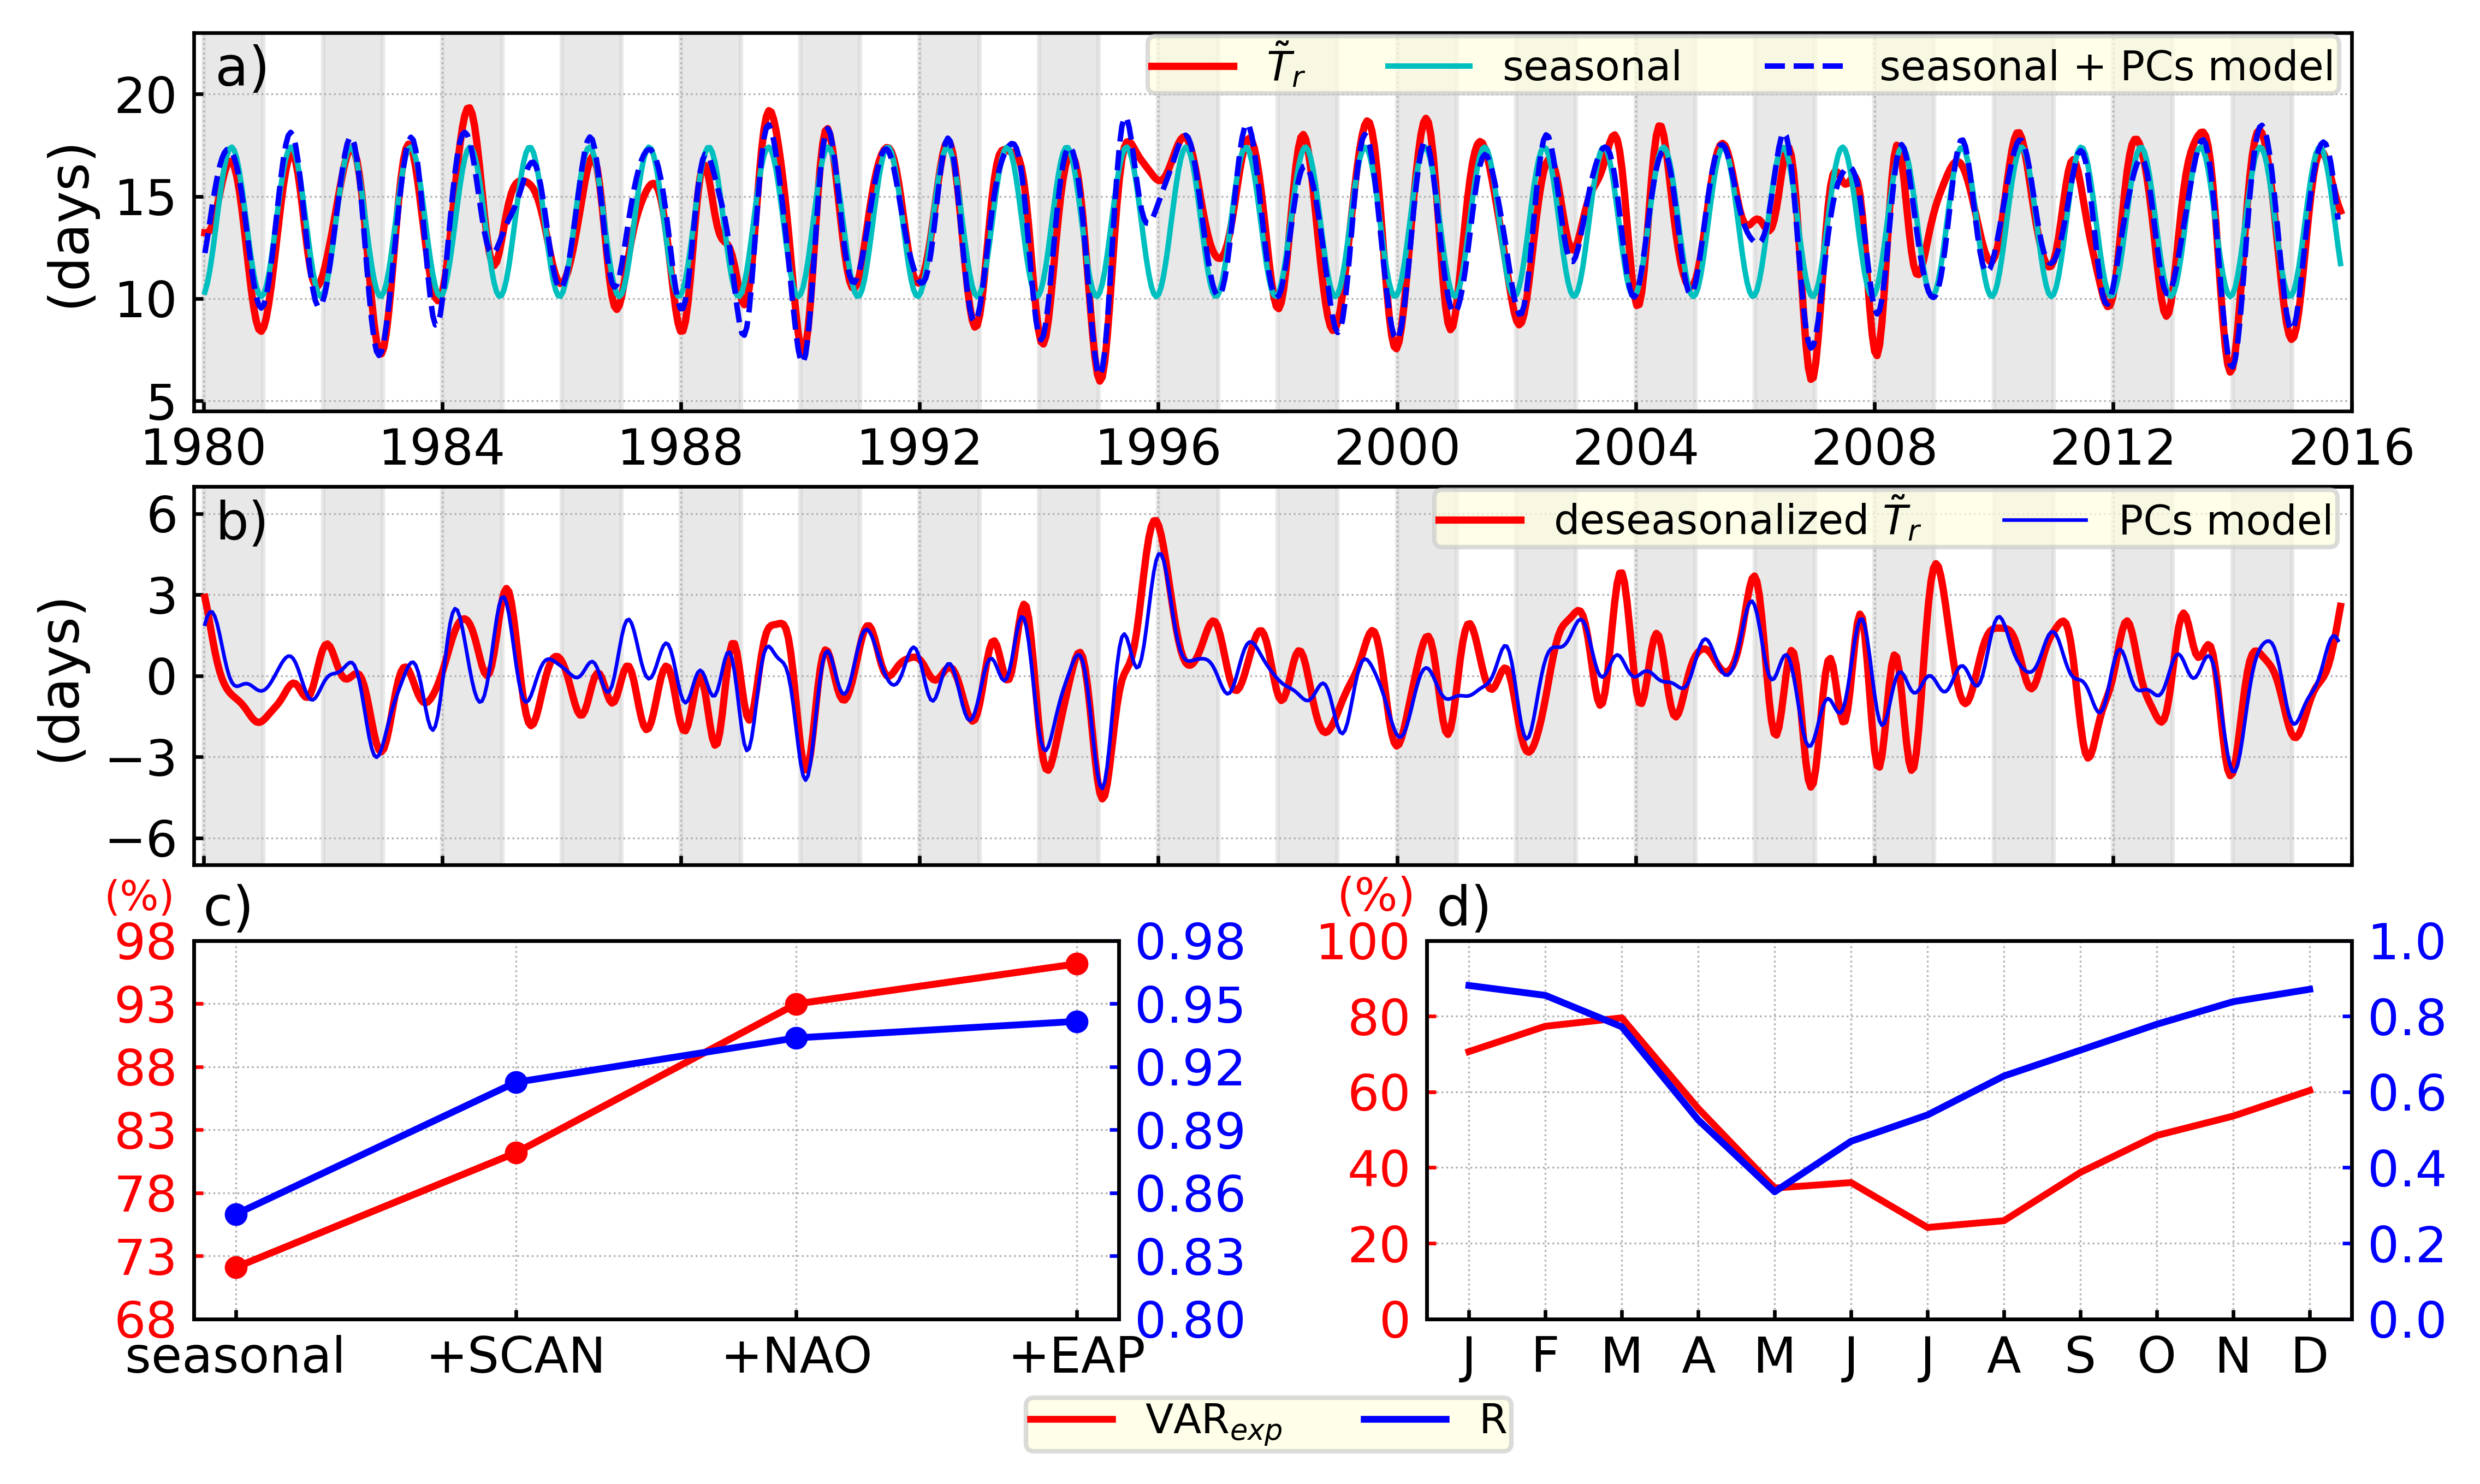

In [16]:
fig=plot_statistics(ds_Tr_model.Tr_tilde,Tr_result_cum_predictors,Tr_stats,Tr_anom_stats_per_month,variable)
fig_name='f09'
fig.savefig(f'{main_dir}{dir_repo_name}{dir_figures}{agu_number}-{fig_name}.jpg',bbox_inches='tight',pad_inches=0.1,dpi=600)
#fig.savefig(f'{main_dir}{dir_repo_name}{dir_figures}{agu_number}-{fig_name}.pdf',bbox_inches='tight',pad_inches=0.1,dpi=600)

### Exposure Time Te

In [17]:
variable="Te"

In [18]:
#join data and get results for cumulative predictors starting with the seasonality and then the PCs---
Te_result_cum_predictors=pre_proc(ds_Te_model,variable,lag)

In [19]:
#statistics of cumulative reconstruction including seasonality----
#statistics based on Te_tilde
Te_stats=get_statistics(ds_Te_model.Te_tilde,Te_result_cum_predictors,lag)
Te_stats

<xarray.Dataset>
Dimensions:     (predictors: 4)
Coordinates:
  * predictors  (predictors) <U8 'seasonal' '+SCAN' '+NAO' '+EAP'
Data variables:
    rmse        (predictors) float64 3.083 2.348 2.104 1.969
    stde        float64 5.044
    rmse_norm   (predictors) float64 61.12 46.55 41.7 39.03
    var_exp     (predictors) float64 62.5 75.3 86.98 91.66
    R2          (predictors) float64 0.6264 0.7833 0.8261 0.8477
    sqrtR2      (predictors) float64 0.7915 0.885 0.9089 0.9207
    r           (predictors) float64 0.7915 0.8852 0.9092 0.9214

In [20]:
#monthly statistics of cumulative reconstruction of only PCs----
#statistics based on deseasonalized Te_tilde
Te_anom_stats_per_month=get_statistics_clim(ds_Te_model.Te_tilde,Te_result_cum_predictors,lag,anom=True)

stats using all PCs:
rmse [1.85 1.88 1.96 1.92 1.67 1.78 2.21 2.36 2.26 1.97 1.78 1.81]
stde [4.14 3.85 3.02 2.3  2.   2.2  2.64 2.92 3.   3.   3.26 3.81]
rmse_norm [44.81 48.78 64.89 83.53 83.41 80.91 83.68 80.74 75.28 65.91 54.63 47.59]
var_exp [80.68 85.03 86.48 58.   34.14 28.91 18.06 18.44 31.55 50.24 63.8  70.45]
R2 [0.8  0.76 0.58 0.3  0.3  0.35 0.3  0.35 0.43 0.57 0.7  0.77]
sqrtR2 [0.89 0.87 0.76 0.55 0.55 0.59 0.55 0.59 0.66 0.75 0.84 0.88]


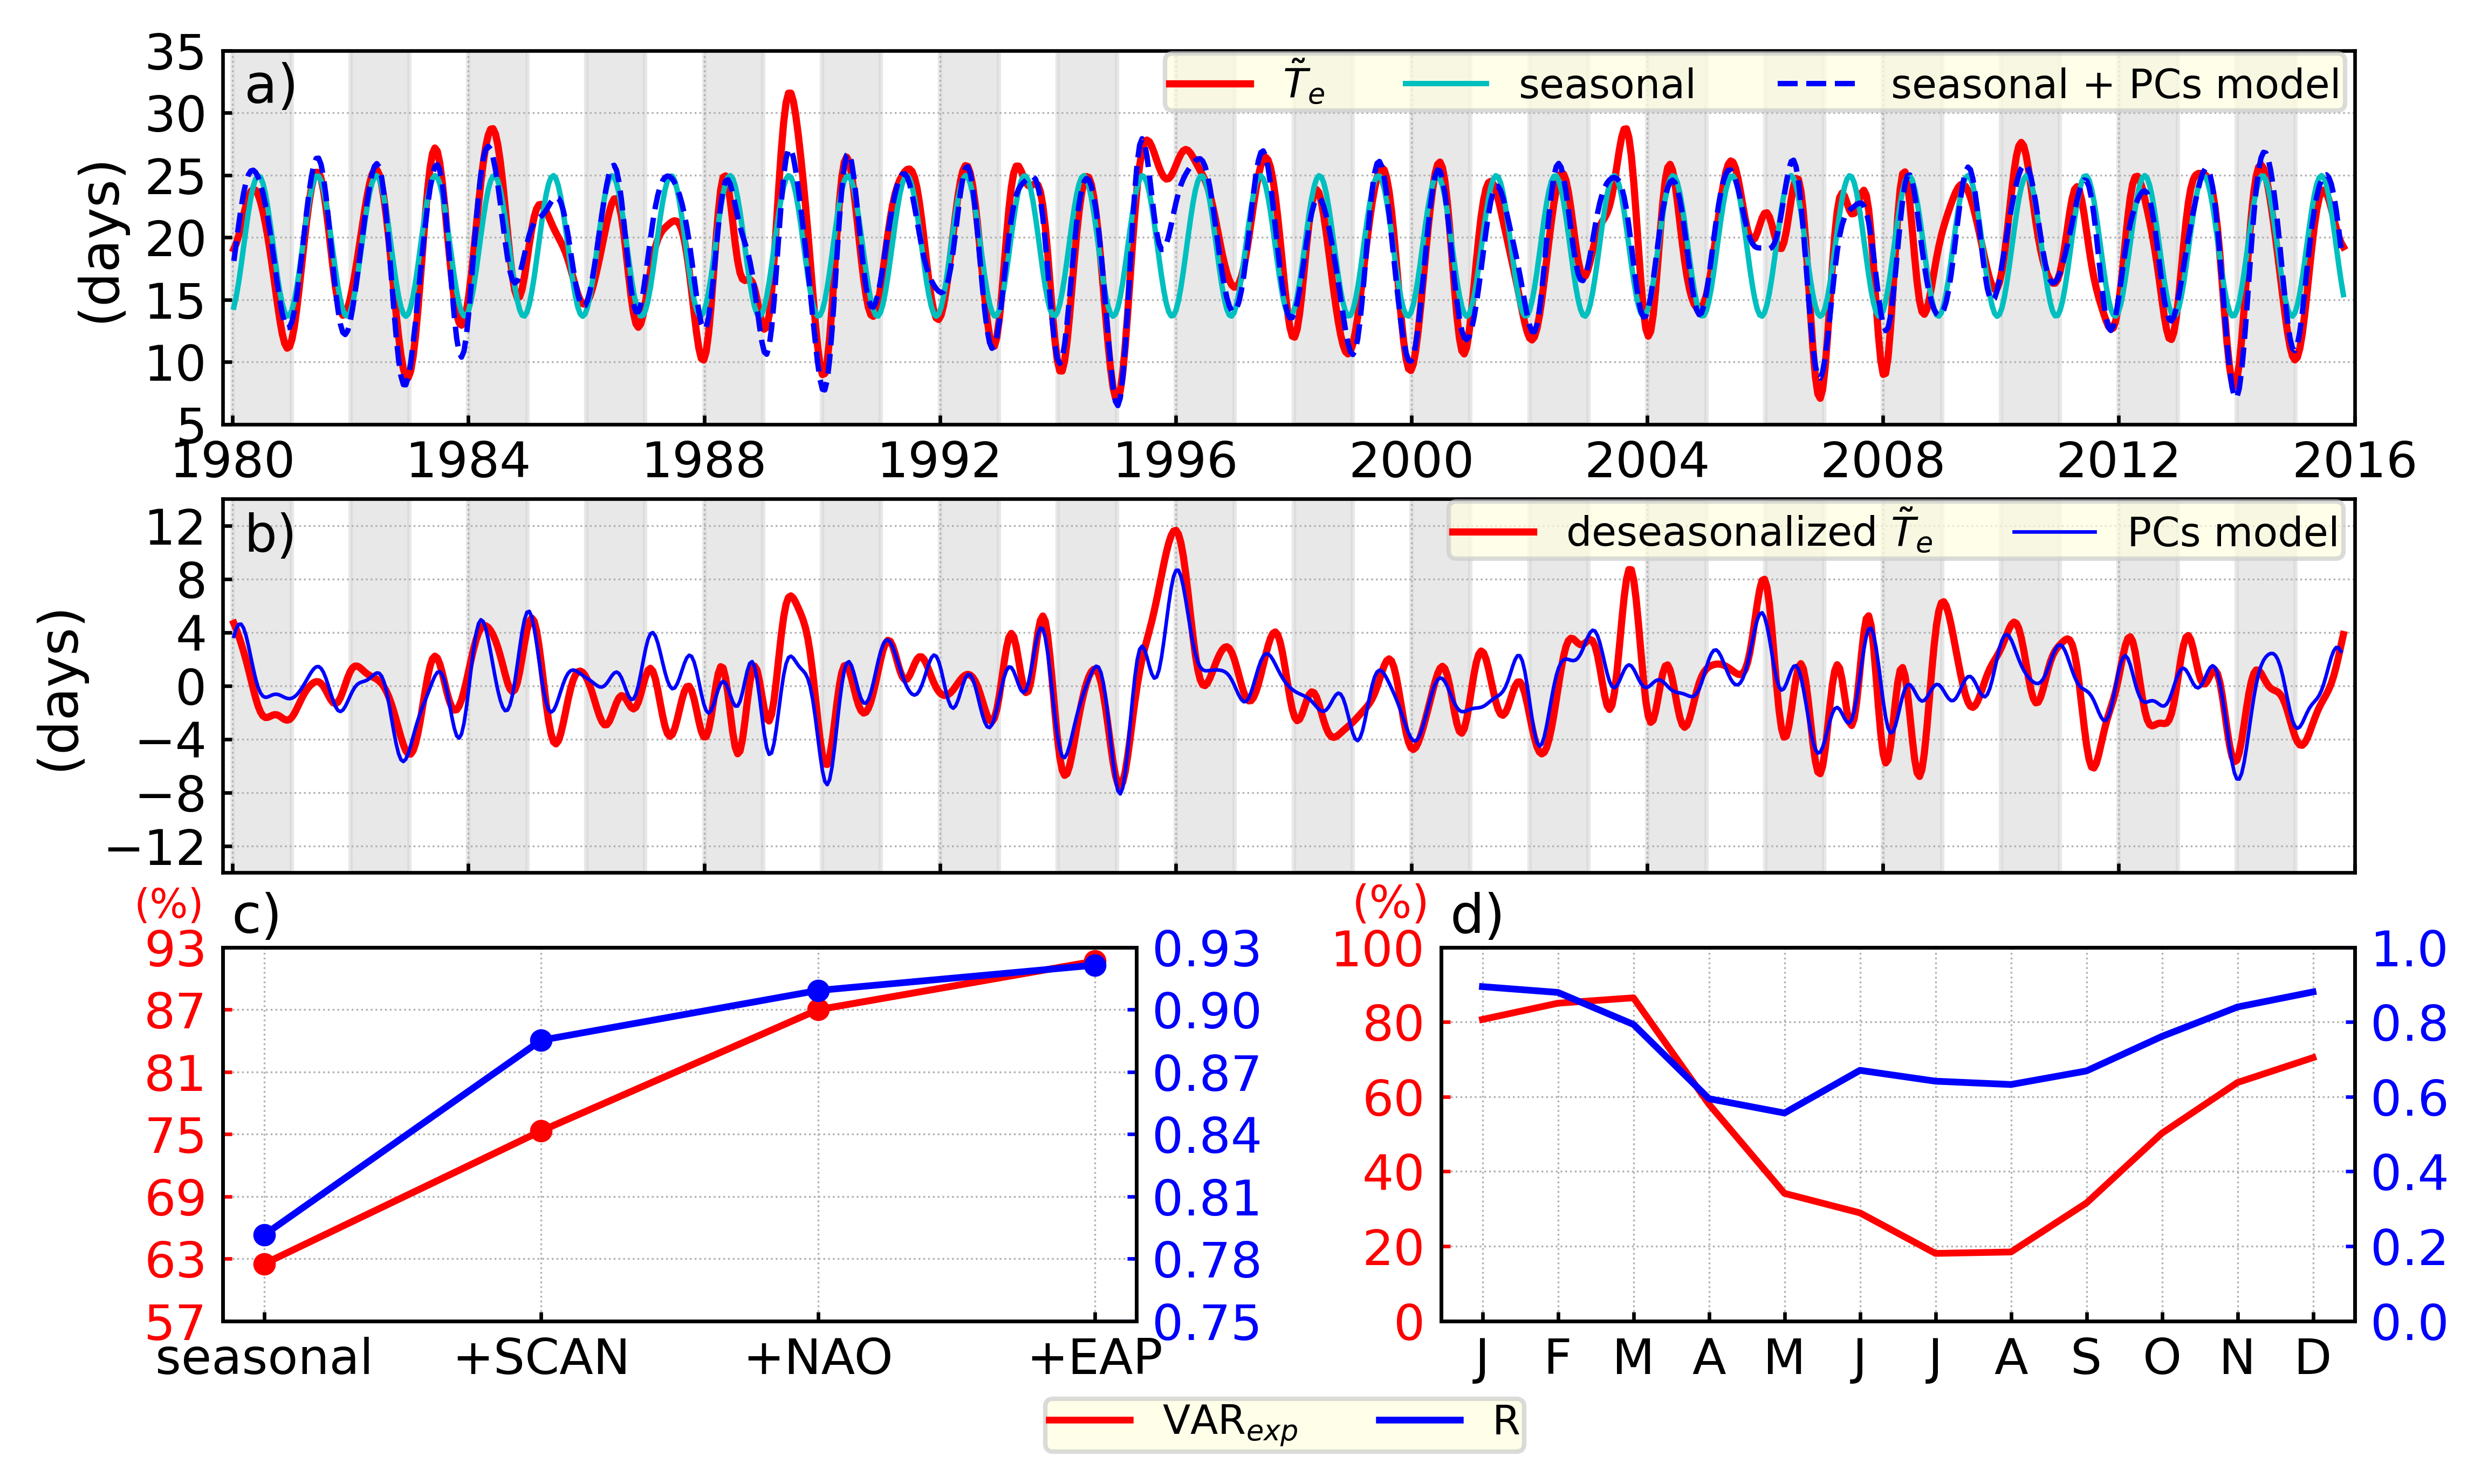

In [21]:
fig=plot_statistics(ds_Te_model.Te_tilde,Te_result_cum_predictors,Te_stats,Te_anom_stats_per_month,variable)
fig_name='f10'
fig.savefig(f'{main_dir}{dir_repo_name}{dir_figures}{agu_number}-{fig_name}.jpg',bbox_inches='tight',pad_inches=0.1,dpi=600)
#fig.savefig(f'{main_dir}{dir_repo_name}{dir_figures}{agu_number}-{fig_name}.pdf',bbox_inches='tight',pad_inches=0.1,dpi=600)